<h1> Car Lane Prediction </h1>

<p align='justify'>

This Jupyter notebook contains a classification example which is
done with the help of Scikit-Learn library. In this notebook,
the following steps are performed:
</p>

<ol align='justify'>
    <li> The preprocessing i.e. feature generation, filtering and
         interpolation of the data is carried out using the
         PTRAIL Library.
    </li>
    <li> Further, several models like RandomForestClassifier, KMeans
         Classifier etc. are trained using the Scikit-Learn library
         based on the cleaned dataset.
    </li>
    <li>
        Finally, on the interpolated dataset, the lane of the vehicle
        is predicted.
    </li>

In [1]:
# Import the dataset.

import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from datetime import datetime

pdf = pd.read_csv('https://raw.githubusercontent.com/YakshHaranwala/PTRAIL/main/examples/data/traffic.csv')

# Modifying the datetime values to make it correct format.
lst = []
for i in range(len(pdf)):
    lst.append(pd.to_datetime(datetime.strptime(str(int(pdf.iloc[i]['datetime'])), "%H%M%S%f")))
pdf['datetime'] = lst

# Now converting the dataframe to PTRAILDataFrame.
np_traffic = PTRAILDataFrame(data_set=pdf  ,
                             latitude='lat',
                             longitude='lon',
                             datetime='datetime',
                             traj_id='id')
np_traffic.head()

vehicle_type  velocity  traffic_lane  \
traj_id DateTime                                                        
1371    1900-01-01 07:30:00.000             1      48.0             2   
        1900-01-01 07:30:00.100             1      47.9             2   
        1900-01-01 07:30:00.200             1      47.9             2   
        1900-01-01 07:30:00.300             1      47.9             2   
        1900-01-01 07:30:00.400             1      47.9             2   

                                        lon        lat  kilopost  \
traj_id DateTime                                                   
1371    1900-01-01 07:30:00.000  135.469950  34.710999    3539.5   
        1900-01-01 07:30:00.100  135.469957  34.710991    3532.5   
        1900-01-01 07:30:00.200  135.469963  34.710984    3532.5   
        1900-01-01 07:30:00.300  135.469968  34.710979    3531.5   
        1900-01-01 07:30:00.400  135.469972  34.710974    3530.8   

                                 vehicle_length  detected_flag  
traj_id DateTime                                                
1371    1900-01-01 07:30:00.000             3.0              0  
        1900-01-01 07:30:00.100             3.0              0  
        1900-01-01 07:30:00.200             3.0              0  
        1900-01-01 07:30:00.300             3.0              0  
        1900-01-01 07:30:00.400             3.0              0

In [2]:
%%time

# First, we will generate distance between consecutive points
# and will run hampel filter on the basis of that.
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.filters import Filters

np_traffic_dist = KinematicFeatures.create_distance_column(np_traffic)
filt_traffic = Filters.hampel_outlier_detection(np_traffic_dist,
                                                column_name='Distance')
print(f"Length of original DF: {len(np_traffic_dist)}")
print(f"Length of filtered DF: {len(filt_traffic)}")

Length of original DF: 44905
Length of filtered DF: 44628
CPU times: user 157 ms, sys: 160 ms, total: 318 ms
Wall time: 4.7 s


/home/yjharanwala/Desktop/PTRAIL/ptrail/preprocessing/filters.py:762: UserWarning: If kinematic features have been generated on the dataframe, then make sure to generate them again as outlier detection drops the point from the dataframe and does not run the kinematic features again.
  warnings.warn("If kinematic features have been generated on the dataframe, then make "


In [3]:
# Now, lets drop duplicate points from the dataset.

dp_traffic = Filters.remove_duplicates(filt_traffic)
print(f"Length of original DF: {len(filt_traffic)}")
print(f"Length of filtered DF: {len(dp_traffic)}")

Length of original DF: 44628
Length of filtered DF: 44628


In [4]:
# Finally, before interpolation, lets remove points
few_filt_traffic = Filters.remove_trajectories_with_less_points(dp_traffic)
print(f"Length of original DF: {len(dp_traffic)}")
print(f"Length of filtered DF: {len(few_filt_traffic)}")

Length of original DF: 44628
Length of filtered DF: 44626


In [5]:
# Now, we generate kinematic statistics on the DF and then change the
# representation of the Trajectory to be segment based instead of point based.
from ptrail.preprocessing.statistics import Statistics

stats_df = Statistics.generate_kinematic_stats(dataframe=few_filt_traffic,
                                               target_col_name='traffic_lane')
pivoted = Statistics.pivot_stats_df(dataframe=stats_df,
                                    target_col_name='traffic_lane')
pivoted

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,traffic_lane
traj_id,,,,,,,,,,,,,,,,,,,,,
1416,0.315801,0.481403,0.890969,1.172964,1.258224,0.210225,1.578175,0.834495,0.369032,62.811307,...,-13.491014,-5.362361,-0.000013,5.332034,13.130373,-60.912916,74.644980,0.291726,12.927129,2
1425,0.382658,0.481403,0.741517,0.967493,1.133012,0.219006,2.729897,0.761500,0.350229,62.765455,...,-14.101735,-6.576577,-0.000011,6.508720,15.355460,-71.632031,77.070853,0.629431,14.360214,2
1446,0.516901,0.609111,0.739260,0.885660,1.008113,0.313507,1.355297,0.754435,0.197112,63.751666,...,-10.384574,-4.990751,-0.000016,5.777198,10.720658,-33.510442,38.665345,0.540908,8.955697,1
1452,0.465608,0.713482,0.822010,1.034889,1.146780,0.181455,2.653599,0.852796,0.303631,64.259693,...,-10.420561,-4.939017,-0.000008,5.957188,11.061478,-43.334245,34.672825,0.619928,9.393139,1
1439,0.556544,0.657456,0.743194,0.828245,0.952170,0.480107,1.889985,0.754809,0.156397,51.495890,...,-9.634646,-5.175728,-0.000016,5.175693,10.280742,-37.166516,43.082172,0.278960,8.868896,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,0.634700,0.980342,1.419185,1.443938,1.462266,0.528250,1.467599,1.205377,0.332115,3.235910,...,-3.577056,-2.749372,-0.793564,2.929407,4.703671,-6.789623,18.857395,0.349801,5.219687,2
1478,1.021491,1.043055,1.075582,1.113689,1.335898,1.021105,1.406627,1.121708,0.119851,3.493505,...,-9.957898,-5.609105,1.712248,6.701907,9.601290,-13.435516,22.794051,1.011458,8.962980,2
1479,1.028282,1.052515,1.120213,1.160782,1.165672,1.014301,1.172680,1.106898,0.061670,1.839717,...,-4.404955,-3.248148,-1.289614,0.245603,1.769426,-5.400099,2.895606,-1.360197,2.741049,2


In [6]:
# Step-5: Getting the test and train datasets ready.
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(pivoted.drop(columns=['traffic_lane']), pivoted['traffic_lane'],
                                                    random_state=7, test_size=0.2)

In [11]:
# Now it is time to train some models and predict
# the ship types.

# 1. RandomForestClassifier model.
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
rf_train_predict = rf_model.predict(X_train)
rf_test_predict = rf_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
rf_train_accuracy = f1_score(y_train, rf_train_predict, average='weighted')
rf_test_accuracy = f1_score(y_test, rf_test_predict, average='weighted')

print('---------------- RandomForest Classifier -----------------')
print(f"The f1_score of RF training is: {round(rf_train_accuracy*100, 2)}%")
print(f"The f1_score of RF testing is: {round(rf_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 2. DecisionTree Classifier model.
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
dt_train_predict = dt_model.predict(X_train)
dt_test_predict = dt_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
dt_train_accuracy = f1_score(y_train, dt_train_predict, average='weighted')
dt_test_accuracy = f1_score(y_test, dt_test_predict, average='weighted')

print('---------------- DecisionTree Classifier -----------------')
print(f"The f1_score of DT training is: {round(dt_train_accuracy*100, 2)}%")
print(f"The f1_score of DT testing is: {round(dt_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 3. Gaussian Naive Bayes model.
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
gnb_train_predict = gnb_model.predict(X_train)
gnb_test_predict = gnb_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
gnb_train_accuracy = f1_score(y_train, gnb_train_predict, average='weighted')
gnb_test_accuracy = f1_score(y_test, gnb_test_predict, average='weighted')

print('----------------- Naive Bayes Classifier -----------------')
print(f"The f1_score of GNB training is: {round(gnb_train_accuracy*100, 2)}%")
print(f"The f1_score of GNB testing is: {round(gnb_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 4. K-Nearest Neighbors Classifier model.

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
knn_train_predict = knn_model.predict(X_train)
knn_test_predict = knn_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
knn_train_accuracy = f1_score(y_train, knn_train_predict, average='weighted')
knn_test_accuracy = f1_score(y_test, knn_test_predict, average='weighted')

print('--------------------- KNN Classifier ---------------------')
print(f"The f1_score of KNN training is: {round(knn_train_accuracy*100, 2)}%")
print(f"The f1_score of KNN testing is: {round(knn_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

---------------- RandomForest Classifier -----------------
The f1_score of RF training is: 100.0%
The f1_score of RF testing is: 80.0%
----------------------------------------------------------

---------------- DecisionTree Classifier -----------------
The f1_score of DT training is: 100.0%
The f1_score of DT testing is: 67.69%
----------------------------------------------------------

----------------- Naive Bayes Classifier -----------------
The f1_score of GNB training is: 83.75%
The f1_score of GNB testing is: 68.0%
----------------------------------------------------------

--------------------- KNN Classifier ---------------------
The f1_score of KNN training is: 85.95%
The f1_score of KNN testing is: 62.17%
----------------------------------------------------------



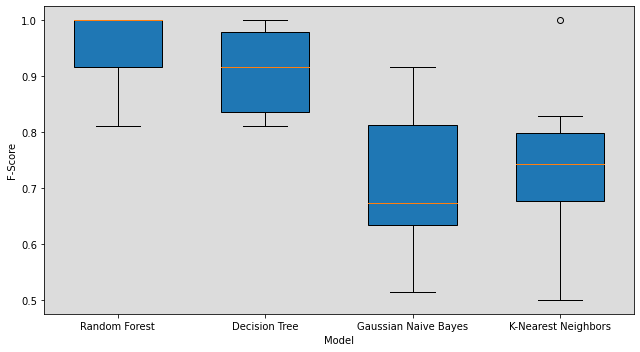

In [12]:
# Let's visualize the scores using box plot of cross validation of the models.
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.simplefilter(category=UserWarning, action="ignore")

names = ["Random Forest", "Decision Tree", "Gaussian Naive Bayes", "K-Nearest Neighbors"]
models = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted.drop(columns=['traffic_lane']), pivoted['traffic_lane'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,
               widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F-Score")
ax.set_xlabel("Model")
plt.tight_layout()